### Customizing Ragas for your use case


This tutorial will teach you how to use a customized version of the Ragas framework for the Datadog Ragas integration. 

### Setup and Pre-requisites

Make sure you've followed the instructions in the `README` file to set up your environment to enable LLM Observability.

We'll also need to install some dependencies for this tutorial

In [1]:
%pip install llama-index=="0.10.42" ragas --quiet


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Enable LLM Observability & Ragas Faithfulness

In [2]:
import os

os.environ["_DD_LLMOBS_EVALUATORS"] = "ragas_faithfulness"
os.environ["_DD_LLMOBS_EVALUATOR_SAMPLING_RULES"] = (
    '[{"sample_rate": 1, "evaluator_label": "ragas_faithfulness", "span_name": "augmented_generation"}, {"sample_rate": 0}]'
)

In [ ]:
from ddtrace.llmobs import LLMObs

LLMObs.enable(ml_app="support-ml-obs", agentless_enabled=True)

### Create & instrument your RAG Application

Create the RAG App just like we did in part 1.

In [4]:
doc_names = [
    "_index",
    "api",
    "auto_instrumentation",
    "core_concepts",
    "quickstart",
    "sdk",
    "span_kinds",
    "submit_evaluations",
    "trace_an_llm_application",
]
raw_doc_source_url = "https://raw.githubusercontent.com/DataDog/documentation/master/content/en/llm_observability"

import requests
from llama_index.core import Document
from llama_index.core.node_parser import MarkdownNodeParser
from llama_index.core import Document
from llama_index.core import VectorStoreIndex

raw_doc_texts = []
for doc_name in doc_names:
    doc = requests.get(f"{raw_doc_source_url}/{doc_name}.md")
    raw_doc_texts.append(Document(text=doc.text))
parser = MarkdownNodeParser()
base_nodes = parser.get_nodes_from_documents(raw_doc_texts)

TOP_K = 2

base_index = VectorStoreIndex(base_nodes)
base_retriever = base_index.as_retriever(similarity_top_k=TOP_K)

In [5]:
from ddtrace.llmobs import LLMObs
from ddtrace.llmobs.decorators import workflow
from ddtrace.llmobs.utils import Prompt


from openai import OpenAI

oai_client = OpenAI()

prompt_template = """
You are an engineer meant to answer support questions about a software product.
The product is LLM Observability by Datadog, a monitoring solution for LLM applications.

You have access to the following reference information: "{context}"
"""


def augmented_generation(question, context):
    with LLMObs.annotation_context(
        prompt=Prompt(variables={"context": context}),
        name="augmented_generation",
    ):
        answer = (
            oai_client.chat.completions.create(
                model="gpt-3.5-turbo",
                messages=[
                    {
                        "role": "system",
                        "content": prompt_template.format(context=context),
                    },
                    {
                        "role": "user",
                        "content": question,
                    },
                ],
            )
            .choices[0]
            .message.content
        )
        return answer


@workflow
def ask_docs(question):
    nodes = base_retriever.retrieve(question)
    context = " ".join([node.text for node in nodes])
    answer = augmented_generation(question, context)
    LLMObs.annotate(input_data=question, output_data=answer)
    return answer

### Customize Ragas

 By default, Ragas uses the `gpt-4o-mini` model. Let's customize ragas to use `gpt-4o` instead. See [here](https://docs.ragas.io/en/stable/howtos/customisations/bring-your-own-llm-or-embs.html) for more information on bringing your own LLM's in Ragas.

In [6]:
from langchain_openai import ChatOpenAI
from ragas.metrics import faithfulness
from ragas.llms.base import LangchainLLMWrapper

faithfulness.llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))

We'll also add a small customization to the prompt Ragas uses that breaks down an answer into seperate statements. For more on customizing prompts, see these instructions on [writing custom prompts with ragas](https://docs.ragas.io/en/stable/howtos/applications/custom_prompts.html)

In [7]:
faithfulness.statement_prompt.instruction += "\nMake sure text containing code instructions are grouped with contextual information on how to run that code."

print(faithfulness.statement_prompt.to_string())

Given a question, an answer, and sentences from the answer analyze the complexity of each sentence given under 'sentences' and break down each sentence into one or more fully understandable statements while also ensuring no pronouns are used in each statement. Format the outputs in JSON.
Make sure text containing code instructions are grouped with contextual information on how to run that code.

The output should be a well-formatted JSON instance that conforms to the JSON schema below.

As an example, for the schema {{"properties": {{"foo": {{"title": "Foo", "description": "a list of strings", "type": "array", "items": {{"type": "string"}}}}}}, "required": ["foo"]}}
the object {{"foo": ["bar", "baz"]}} is a well-formatted instance of the schema. The object {{"properties": {{"foo": ["bar", "baz"]}}}} is not well-formatted.

Here is the output JSON schema:
```
{{"type": "array", "items": {{"$ref": "#/definitions/Statements"}}, "definitions": {{"Statements": {{"title": "Statements", "type

### Run the RAG App

Let's run our RAG workflow and navigate to the Datadog UI.

Looking at the Ragas traces, you should see the faithfulness evaluation use the new X model and your custom prompt!

You can utilize these traces to tweak your custom prompt to improve the accuracy of your faithfulness score.

In [8]:
def generate_question():
    answer = (
        oai_client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {
                    "role": "user",
                    "content": "generate a question about how to setup & best use a SaaS tool to observe LLM-powered applications",
                }
            ],
        )
        .choices[0]
        .message.content
    )
    return answer


for i in range(50):
    question = generate_question()
    print(f"Question {i+1}: {question}")
    answer = ask_docs(question)
    print(f"Answer {i+1}: {answer}")

Question 1: What are the key steps to set up and optimize the use of a SaaS tool for monitoring LLM-powered applications effectively?
Answer 1: Setting up and optimizing the use of a SaaS tool for monitoring LLM-powered applications effectively involves several key steps. Here are some guidelines to help you maximize the benefits of using a tool like LLM Observability by Datadog:

1. **Define Monitoring Objectives**: Clearly outline what you aim to achieve with monitoring. Determine the key metrics, performance indicators, and response quality checks relevant to your LLM applications.

2. **Set Up Monitoring**: Configure the tool to monitor all aspects of your LLM applications, including cost, latency, performance, and usage trends. Ensure you are capturing data from all necessary sources.

3. **Utilize Out-of-the-Box Dashboards**: Take advantage of pre-built dashboards provided by the tool, like the LLM Observability Operational Insights dashboard in Datadog. These help visualize impo

### Seeing the Updated Ragas Trace

Navigate to the Datadog UI, and you see in the ragas traces we are now using a custom prompt & gpt-4o!

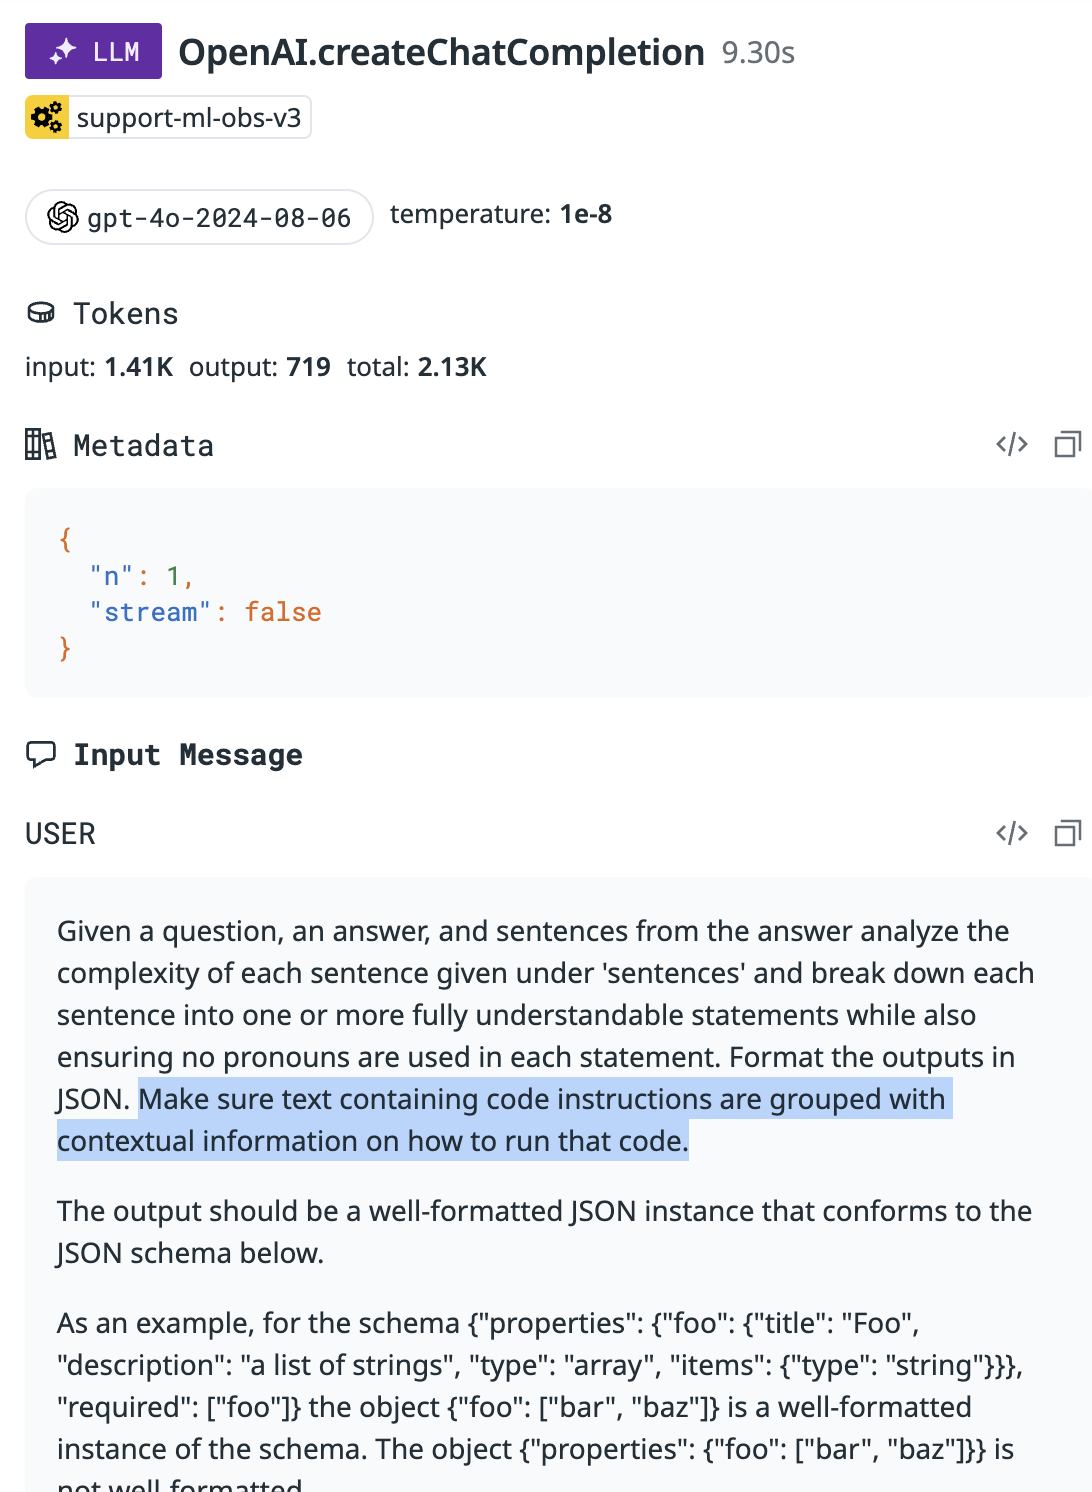